# Multiple comparison correction (MCC)
In this notebook, we'll continue with the topic of multiple comparison correction (MCC).

**What you'll learn**: after this lab, you'll ...

- know the relative advantages and disadvantages of different MCC techniques

**Estimated time needed to complete**: 1 hour<br>
**Credits**: This notebook is based on a blog by [Matthew Brett](https://matthew-brett.github.io/teaching/random_fields.html) and a previous Matlab-based lab by H. Steven Scholte.

## Why do we need MCC?
Univariate analyses of fMRI data essentially test hypotheses about your data (operationalized as contrasts between your $\hat{\beta}$ estimates) *for each voxel* separately. So, in practice, given that the MNI (2 mm) standard template brain contains about 260,000 voxels, you're conducting 260,000 different statistical tests! The obvious problem, here, is that some tests might turn out significant, while they in fact do not contain any (task-related) activity: the result is driven just by chance.

As a researcher, you should strive to "filter out" the results which are driven by noise (*false positives*) and keep the results which are actually driven by the true effect (*true positives*) as much as possible. It turns out that the more tests you do, the larger the chance is that you will find one or more *false positives*. To deal with this, researchers often employ techniques for *multiple comparison correction* (MCC): **correcting** for the inflated chance of false positives when you have **multiple** tests (**comparisons**).

In this tutorial, we will walk you through an example (simulated) dataset on which different MCC techniques are employed. We'll focus on how these different techniques influence the chance for finding false positives.

### The example
We'll work with the (simulated) group-level results of a hypothetical fMRI experiment. Suppose that the subjects in our hypothetical experiment were shown pictures of cats in the scanner, because we (the experimenters) were interested in which voxels would (de)activate significantly in reponse to these cat pictures (i.e. a contrast of the cat-picture-condition against baseline).

An example of an image shown to the subjects:
![test](cute_cat.jpeg)

After extensive preprocessing, we fitted first-level models in which we evaluated the cat-against-baseline contrast, in which the $t$-statistic refers to how strongly each voxel responded to the pictures of cats. After doing a proper group-level analysis, we now have a group-level $t$-statistic map, reflecting whether voxels on average (de)activated in response to the pictures of cats.  

<div class='alert alert-info'>
<b>ToThink</b> (0.5 point): On average, what group-level $t$-statistic would you (approximately) expect to find if, in fact, there would be no voxel which reliably (de)activated in response to the cat-pictures?
</div>

YOUR ANSWER HERE

## The data
Usually, your whole-brain group-level results are 3D $z$- or $t$-statictic maps of the size of a standard brain (usually the MNI 2mm template, which has about 260,000 voxels). Plotting in 3D, however, is incredibly cumbersome, so for the sake of the example, we'll assume that our group-level results are represented as a 2D $z$-statistic map, with dimensions $200 \times 200$. So, we'll pretend we analyzed the results based on a 2D brain with $200 \times 200$ "voxels". 

Because we work with simulated data, we can actually specify the "true effect". In reality, we never know this of course! We are going to assume that there is a small "blob" of voxels in the middle of our "brain" that activates reliably to pictures of cats (with a $z$-value of 5.5). This blob is therefore the true effect in our simulation. 

Let's first simulate the data.

In [1]:
import numpy as np

# You don't have to understand how this simulation works exactly
k = 200  # number of vox in each dimension
signal = np.zeros((k, k))
r = 10  # middle of the image
a, b = k // 2, k // 2  # width and height of the circle
y, x = np.ogrid[-a:k-a, -b:k-b]
mask = x * x + y * y <= r * r
signal[mask] = 5.5  # amplitude of effect!

print("Shape of statistic map: %s" % (signal.shape,))

Shape of statistic map: (200, 200)


Alright, now let's plot the true effect as a 2D image. We'll define a custom function for this, `plot_sim_brain`, to save us some work later.

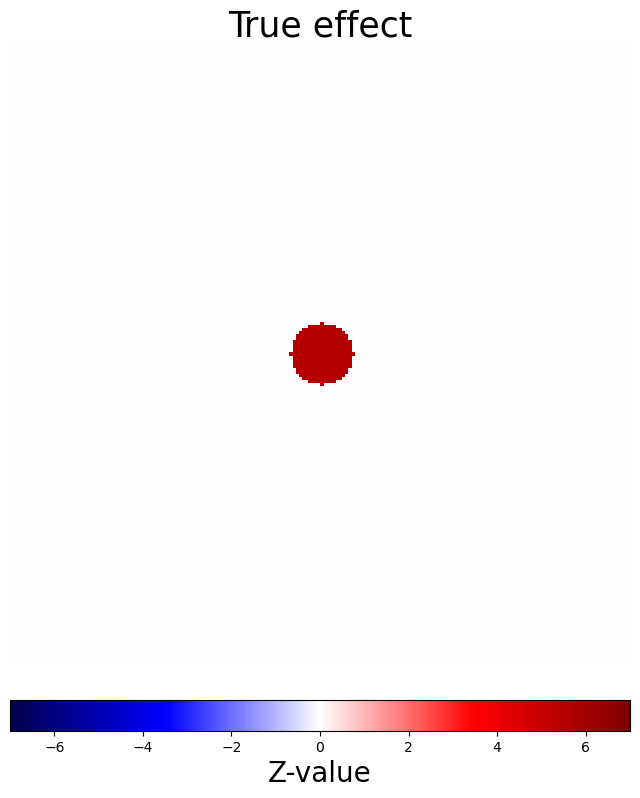

In [2]:
import matplotlib.pyplot as plt

def plot_sim_brain(brain, mask=None, vmin=-7, vmax=7, cmap='seismic', title='', label='Z-value'):
    """ Plots an image of a simulated 2D 'brain' with statistic values, which may be 'masked'.
    
    Parameters
    ----------
    brain : numpy array
        A 2D numpy array with statistics
    mask : numpy array (or None)
        A 2D numpy array with booleans (True = do plot, False = do not plot). If None,
        the 'brain' is not masked.
    vmin : int/float
        Minimum value of colorbar
    vmax : int/float
        Maximum value of colorbar
    cmap : str
        Name of colormap to use
    title : str
        Title of plot
    label : str
        Label for colorbar
    """
    
    brainm = brain.copy()
    if mask is not None:  # threshold!
        brainm[~mask] = 0

    plt.figure(figsize=(8, 10))
    plt.imshow(brainm, vmin=vmin, vmax=vmax, aspect='auto', cmap=cmap)
    plt.axis('off')
    plt.title(title, fontsize=25)
    
    cb = plt.colorbar(orientation='horizontal', pad=0.05)
    cb.set_label(label, fontsize=20)
    plt.show()
    
plot_sim_brain(signal, title="True effect")

Now, due to the inherent spatial smoothness of fMRI, this particular manifestation of the effect is not very realistic. In particular, the sharp "edges" of the effect are unlikely to occur in real fMRI data. Therefore, to make it a little more realistic, we can spatially smooth the "true effect map"! We will use the `gaussian_filter` function (from `scipy.ndimage`) with a FWHM of 12 "voxels". 

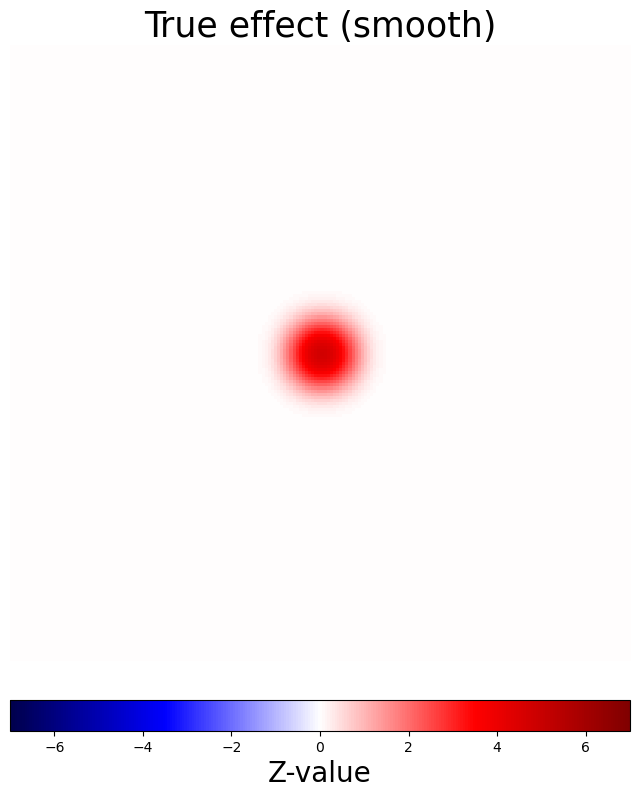

In [3]:
from scipy.ndimage import gaussian_filter

fwhm = 12
# Convert FWHM to sigma
sigma = fwhm / np.sqrt(8 * np.log(2))
signal_smooth = gaussian_filter(signal, sigma=sigma)
plot_sim_brain(signal_smooth, title="True effect (smooth)")

As you've learned in the past weeks, the chances are very slim that you'll find such a "crisp" (true) effect as shown above; often, you might observe significant voxels that are not driven by a true effect, but by (spurious) noise, reflecting false positives.

So, let's make our data a little more realistic by simulating some random noise, sampled from a normal distribution with mean 0 and a standard deviation of 1. Importantly, we are also going to smooth our noise with the same gaussian filter (with FWHM = 12): 

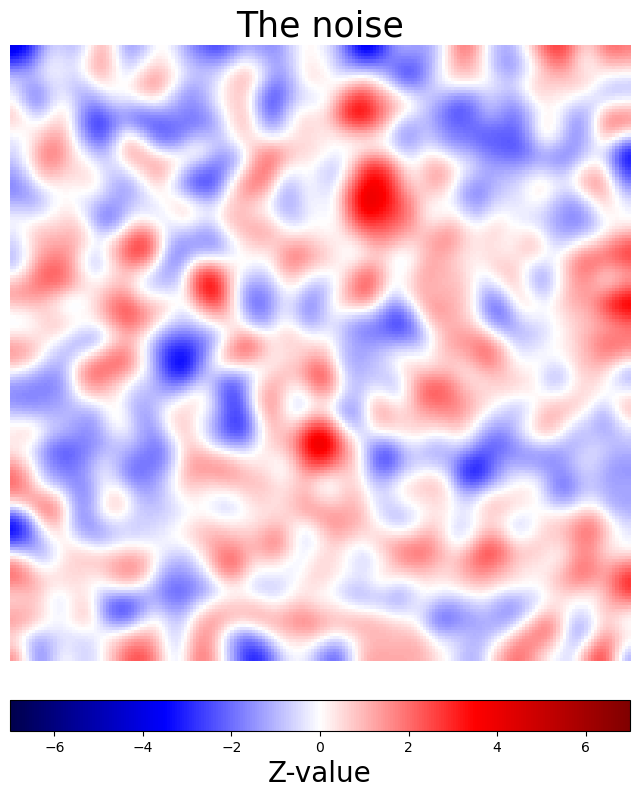

In [4]:
np.random.seed(2)  # for reproducibility
noise = np.random.normal(0, 1, size=signal.shape)
noise = gaussian_filter(noise, sigma=sigma)
noise = noise / noise.std()

plot_sim_brain(noise, title='The noise')

Now, to complete our simulation, we'll simply add the signal and the noise together (we'll call this variable `data`).

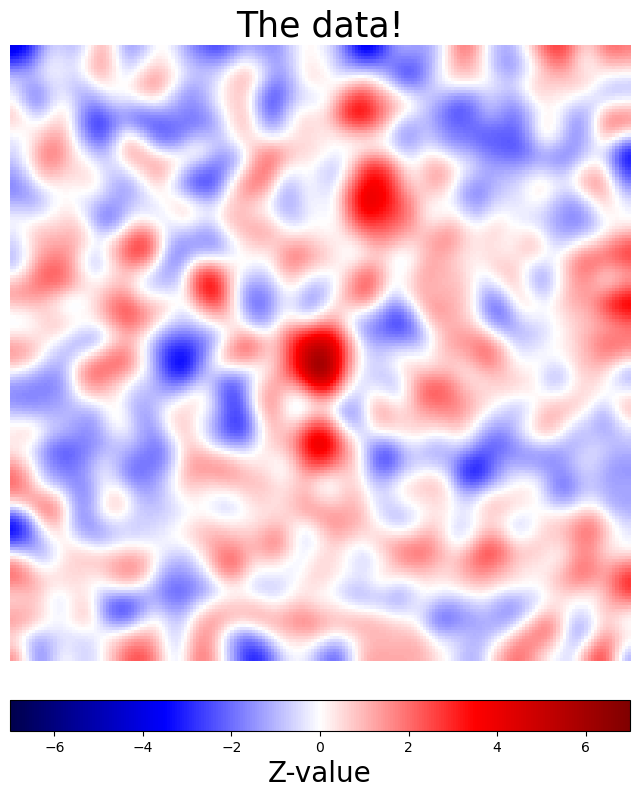

In [5]:
data = signal_smooth + noise
plot_sim_brain(data, title='The data!')

The plot above now represents our simulated data, which contains both a true signal (the "blob" in the middle) and some (spatially correlated) noise. As a researcher, you aim to threshold your data in such a way that you maximize the chance of finding your true signal (true positive effects) and minimize the chance of erroneously treating noise as significant effects (false positive effects).

## Uncorrected statistics maps
In the early days of fMRI analyses, the extent of the MCC problem (more tests = more false positives) was not yet widely known. What researchers simply did was to calculate the $p$-values corresponding to the $z$-value (or $t$-value) maps and threshold those $p$-values using some fixed cutoff ("alpha value"), usually 0.05 or 0.01. 

To implement this, we can convert all our $z$-values to $p$-values, compute a "mask" (i.e., an array with `True` and `False` values, indicating which "voxels" survive the threshold and which do not), and set all "voxels" outside the mask to 0. 

Let's choose a significance level ($\alpha$) of 0.05.

In [14]:
alpha = 0.08

Now, let's convert the $z$-values (in the variable `data`) to $p$-values. We'll use the `stats.norm.sf` function from the `scipy` package for this. (This is the same type of function &mdash; a "survival function" &mdash; that we used to calculate the $p$-values corresponding to $t$-values before, but this time we use it for $z$-values)

In [8]:
# This line converts the z-values to p-values
from scipy import stats

data_pvals = stats.norm.sf(data); data_pvals

array([[0.99993485, 0.99991908, 0.99987596, ..., 0.03654638, 0.04017426,
        0.04246401],
       [0.99990874, 0.99988756, 0.9998304 , ..., 0.04150034, 0.04533445,
        0.04774669],
       [0.99982678, 0.99979003, 0.99969309, ..., 0.05254633, 0.0567613 ,
        0.05939816],
       ...,
       [0.12892669, 0.15703852, 0.22006558, ..., 0.60224099, 0.70255286,
        0.75060819],
       [0.10360983, 0.12937065, 0.18908486, ..., 0.64897472, 0.74923302,
        0.7954434 ],
       [0.09115718, 0.11545102, 0.17287048, ..., 0.6737411 , 0.77299859,
        0.81773326]])

<div class='alert alert-warning'>
    <b>ToDo</b> (1 point): Compute how many voxels are deemed to be "significant" (assuming $\alpha = 0.05$), using the variable <tt>data_pvals</tt>, in this approach in which we neglect the multiple comparison approach. Store this number (an integer) in a new variable named <tt>nsig_uncorrected</tt>.
</div>

In [ ]:
# Implement your ToDo here
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
''' Tests the above ToDo. '''
from niedu.tests.nii.week_6 import test_nsig_uncorrected   
test_nsig_uncorrected(data_pvals, alpha, nsig_uncorrected)

We can create a "mask" by comparing our $p$-values to our significance level and we can give this mask to our plotting-function (`plot_sim_brain`), which will set all "voxels" outside the mask (i.e., those which are `False` in the mask) to 0. 

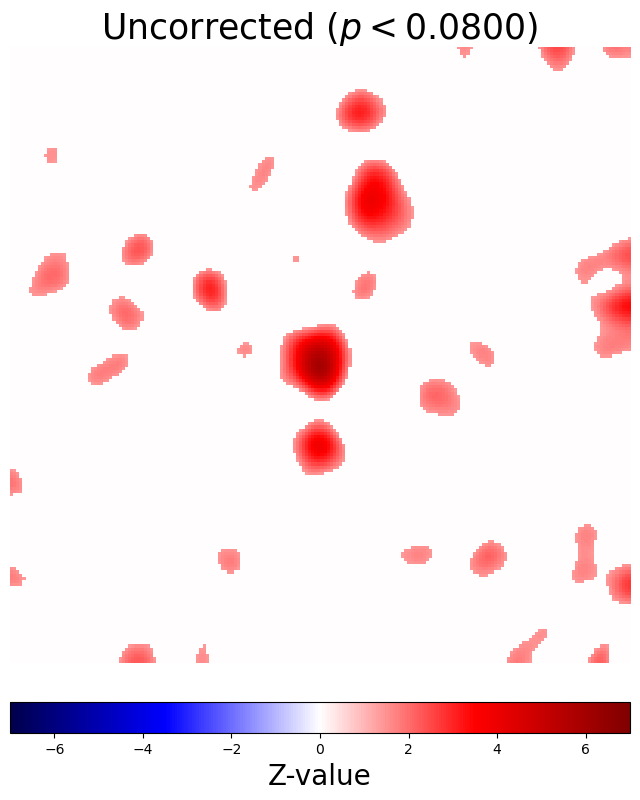

In [15]:
smaller_than_alpha = data_pvals < alpha
# Note that 'smaller_than_alpha' is a 2D numpy array with booleans

plot_sim_brain(data, mask=smaller_than_alpha, title=r'Uncorrected ($p < %.4f$)' % alpha)

<div class='alert alert-warning'>
    <b>ToDo/ToThink</b> (1 point): Change the value of $\alpha$ (i.e., the variable <tt>alpha</tt>) from before to 0.01. Does the resulting thresholded map look "better"? And what about 0.001? And 0.0001? Theoretically, you could try different values to see what gives the "best" results. This practice of trying out different parameters or strategies leads to another problem: can you think of what this could be? Write down your answer below.
</div>

YOUR ANSWER HERE

## Bonferroni-correction
Obviously, given that we know our "true effect", we can see that the uncorrected results contain *a lot* of false positives, something that we'd like to avoid! The most obvious way to counter the MCC problem is to adjust the significance level ($\alpha$) by the amount of tests we're performing. Bonferroni correction is such an approach. The way the Bonferroni method does this is by simply dividing the significance level by the amount of tests.

<div class='alert alert-warning'>
<b>ToDo</b> (1 point): Calculate the Bonferroni-adjusted significance level (and store this in a variable named <tt>bonf_alpha</tt>) and create a new mask by comparing the previously computed $p$-values against this new significance level. Then, plot the data (using <tt>plot_sim_brain</tt>) with the mask you just created.
</div>

In [18]:
""" Implement the ToDo here. """

# YOUR CODE HERE
bonf_alpha = alpha / data.size; bonf_alpha

# raise NotImplementedError()

2e-06

In [ ]:
''' Tests the above ToDo. '''
from niedu.tests.nii.week_6 import test_bonferroni_alpha
test_bonferroni_alpha(alpha, data, bonf_alpha)

<div class='alert alert-info'>
<b>ToThink</b> (not graded): Many argue that Bonferroni correction for whole-brain fMRI results is too strict (conservative), which is also the case in our simulation (the recovered "blob" is a lot smaller than the true effect).

This conservative nature of Bonferroni correction, for fMRI at least, is due to the violation of a crucial assumption of Bonferroni correctoin. Which assumption is this, and why does fMRI data/results likely violate this assumption?
</div>

YOUR ANSWER HERE

The Bonferroni correction operates under the assumption that each voxel represents a independent statistical test. However, activity in neighboring voxels is likely to be highly correlated. Also spatial smoothing adds to this!!
Spatial smoothing increases the SNR of the data, because noise gets averaged out / canceled. However, each voxel intensity is replaced by a weighted average of neighboring intensities.

Bonferroni correction adjusts the single-voxel threshold in such a way that we retain an error prob. of 0.05 at the global level. In order to guarantee a global or family-wise error (FWE) probability of pFWE = 1-(1-p)N, the threshold for a single test, p, has to be adjusted as follows: p = 1-(1-pFWE)1/N. 
The methods controlls the alpha error across all! voxels, and is therefore called a family-wise correction approach.

**Independence Problem in fMRI**: The Bonferroni method would be a valid approach to correct the alpha error if the data at neighboring voxels would be truly independent from each other.
Neighboring voxels, however, show similar response patterns within functionally defined brain regions. 

In the presence of spatial correlations, it would operate too conservative. As a result of a too strict control of the alpha error, the sensitivity (power) to detect truly active voxels is reduced: many voxels will be labeled as non-significant although they would reflect true effects.

**Too many false negatives (increased beta error) with bonferroni correction**

## FDR correction
As you've seen so far, uncorrected results tend to be too liberal (too many false positives) and Bonferroni-corrected results are too strict (too many false negatives). The "False Discovery Rate-correction" (FDR) technique is a method to adjust $p$-values in a less stringent way. Essentially, while traditional MCC methods (such as Bonferroni) try to control the chance of finding at least one false positive result **amongst all your tests** (i.e. controlling the "familywise error rate" method), the FDR-method tries to limit the proportion of false positives **amongst all your tests which turned out significant**. So, if you set your "FDR-proportion" (confusingly also referred to as "alpha") to 0.05, then it will adjust your initial $p$-values such that out of all your significant results, on average 5% will be false positives.  

In general, FDR-correction is more sensitive than the Bonferroni correction method (i.e. FDR has a lower type 2 error rate/it is less strict), but if you use it, you *do* have to accept that about 5% of your (significant) results are false positives!

Now, let's check out what our results look like after FDR correction:

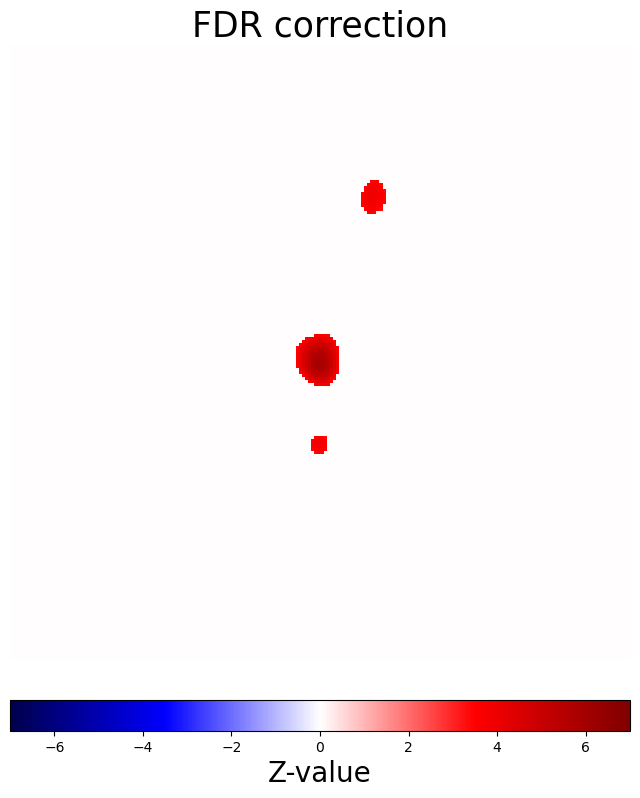

In [19]:
# fdr implementation from statsmodels package
from fdr import fdrcorrection
alpha_fdr = 0.05 # we use an alpha of 0.05 (5%)

# The fdrcorrection function already returns a "mask"
# Note that it doesn't accept 2D arrays, so we ravel() and then reshape() it
fdr_mask = fdrcorrection(data_pvals.ravel(), alpha=alpha_fdr)[0]
fdr_mask = fdr_mask.reshape(data.shape)

plot_sim_brain(data, mask=fdr_mask, title='FDR correction')

As you can see, the FDR-correction is way more sensitive than the Bonferroni correction (it "recovers" more of the true signal), but it still results in many false positives (but not as many as uncorrected data).

Not the overall number of false positive voxels is controlled, but the **number of false positive voxels among the subset of voxels labelled as significant**.
Supra-threshold voxels given a specific thrshold value are called "discovered" voxels or "voxels declared active".

With a FDR < 0.05 one would accept that 5% of the supra-threshold voxels would be false positives.

**In FDR logic**: the number of FP are related to the amount of truly active voxels. FDR method adapts to the amount of activity in the data.

Very strict if there is not much activity in the data, but assumes less conservative thresholds if larger regions of the brain show task-related effects.

## RFT-based correction
As you've seen in the previous examples, it's quite hard to pick a significance level that strikes a good balance between type 1 errors and type 2 errors, or, phrased differently, between sensitivity (with respect to discovering the true signal) and specificy (i.e. how many of our significant voxels are driven by a true effect).

Let's go back to the results of the Bonferroni correction. We've seen that the results are extremely conservative (few false positives, but many false negatives, i.e. large type 2 error). The major reason for this is that the correction assumes that each test is *independent*, but in our simulation (and in any fMRI dataset), we *know* that there exists spatial correlation, meaning that our tests are *not* independent. In other words, if we know that a certain voxel is signficant in a certain test, it is quite likely that the voxel directly *next* (or above/below) to it is also significant. Therefore, spatially correlated fMRI statistic maps violate Bonferroni's assumption of independent tests (this is also the answer to the ToThink from earlier).

As a possible solution to this problem, neuroscientists have developed a method &mdash; random field theory &mdash; that allows for multiple comparison correction (using FWER) that "corrects" for the smoothness in our data and thresholds accordingly.

Importantly, RFT-correction can either be performed at the voxel-level (testing whether the *amplitude*, i.e., height of the statistic of a voxel is significant, given the smoothness of the data) and at the cluster-level (testing whether the *size* of a cluster of voxels is significantly large, given the smoothness of the data). We'll start with voxel-level RFT.

### Voxel-level RFT
Voxel-level RFT allows for "smoothness-adjusted" thresholding for individual voxels. It does so by assuming a particular distribution for the *number of clusters* (or "blobs") one would observe given (1) a particular initial threshold and (2) the smoothness of the data, assuming there is no effect (i.e., the null hypothesis is true). This expected "number of blobs" after thresholding is known as the *Euler characteristic*. And for standard normal data (i.e., $z$-statistics), the expected Euler characteristic is computed as:

\begin{align}
EC = N_{resel}\ (4\ \log_{e}2)\ (2\pi)^{-\frac{2}{3}}\ z\cdot e^{-\frac{1}{2} z}
\end{align}

where $R$ refers to the number of "resels" (a number that depends on the smoothness of your data, which we'll discuss in a bit) and $z$ refers to the $z$-value that you use as an initial threshold. In code, this is:

In [20]:
def expected_EC(z, n_resel):
    """ Computes the expected Euler Characteristic for a given number of resels
    and initial z-value cutoff. 
    
    Parameters
    ----------
    z : int/float or array of int/float
        Initial z-value cutoff (can be array)
    
    n_resel : int/float
        Number of "resels"
    """
    return n_resel * (4 * np.log(2)) * (2 * np.pi) ** (-(2/3)) * z * np.exp(-0.5 * z ** 2)

Importantly, suppose for now that the number of resels is 1000. Then, we can get the expected number of "blobs" in our data for a given $z$-value threshold, let's say $z = 3$, as follows:

In [21]:
zthresh = 3
n_blobs = expected_EC(z=zthresh, n_resel=1000)
print("For a z-threshold of %i, we expect %.2f blobs in random 2D data with 100 resels." % (zthresh, n_blobs))

For a z-threshold of 3, we expect 27.14 blobs in random 2D data with 100 resels.


We can also evaluate the expected EC for a range of potential $z$-value thresholds (e.g., from 0-5) and plot it:

In [22]:
zx = np.linspace(0, 5, 100)  # 100 values between 0 and 5
ecs = expected_EC(zx, n_resel=1000)  # expected EC also works for multiple z-values at once

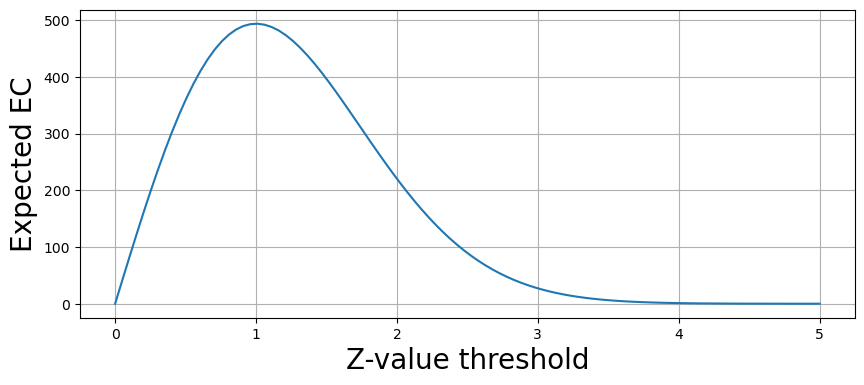

In [23]:
plt.figure(figsize=(10, 4))
plt.plot(zx, ecs)
plt.ylabel('Expected EC', fontsize=20)
plt.xlabel('Z-value threshold', fontsize=20)
plt.grid()

To compute the Euler characteristic, we first need to know how to estimate the number of "resels" for our data. You can think of the number of resels as the number of truly independent elements in your data ("resel" is short for "RESolution ELement"). The number of resels is usually estimated by dividing the number of voxels by the estimated size of the resel. For our simulated 2D data, the number of resels is defined as follows:

\begin{align}
N_{resel} = \frac{N_{X}\cdot N_{Y}}{\mathrm{size}_{resel}}
\end{align}

where $N_{X}$ is the number of "voxels" in the first dimension and $N_{Y}$ the number of "voxels" in the second dimension, and where the resel size ($\mathrm{size}_{resel}$) is estimated as the product of the smoothness of our data in all dimensions, measured in FWHM:

\begin{align}
\mathrm{size}_{resel} = \mathrm{FWHM}_{X} \cdot \mathrm{FWHM}_{Y}
\end{align}

So, given a particular size of our resel, $N_{resel}$ represents how many resels there would "fit" in our data.

<div class='alert alert-warning'>
    <b>ToDo</b> (1 point): Usually, the smoothness of the data has to be estimated (usually from the residuals), but in our simulation, we know the smoothness: it's the FWHM we used for our gaussian filter to smooth out data! Compute the number of resels in our simulated data and store it in a variable named <tt>n_resel</tt>.
</div>

In [31]:
print(data.shape)

(200, 200)


In [ ]:
# Implement your ToDo here

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
''' Tests the above ToDo. '''
from niedu.tests.nii.week_6 import test_n_resel
test_n_resel(data, n_resel)

Now, another way to interpret EC values is as $p$-values: the chance of finding one or more "blobs" for a given $z$-value! This way, we can choose a particular $z$-value threshold that would correspond to $p = 0.05$. We do this below:

In [32]:
ecs = expected_EC(zx, 278)

# find the index of the EC value closest to alpha
idx_z = np.abs(ecs - alpha).argmin()

# Index the z-values with idx_z
z_thresh = zx[idx_z]
print("The z-value threshold corresponding to p = 0.05: %.3f" % z_thresh)

The z-value threshold corresponding to p = 0.05: 4.343


<div class='alert alert-info'>
<b>ToThink</b> (1 point): As you (should) see in the plot above, the RTF-based correction is still quite strict/conservative (i.e. misses quite some of the true effect), although arguably not as strict as Bonferroni correction. Given the way how to calculate the number of RESELS, can you think of two ways on how to improve the sensitivity of RFT-based MCC?
</div>

YOUR ANSWER HERE

### Cluster-level RFT
In all the previous MCC techniques, we have used voxel-level corrections, which resulting $p$-values tell us something about whether the *height* of a voxel's statistic (often referred to as "amplitude") is higher than would be expected under the null-hypothesis. Basically, because we investigated *per voxel* whether its value is higher than expected, we are making inferences on the level of voxels. 

Another type of inference is *cluster*-level inference, in which you do not test the voxel amplitude, but the *size of clusters*. Basically, in this type of cluster-extent testing, you are investigating whether the size of the clusters you find are (significantly) larger than to be expected under the null-hypothesis (i.e., no effect). 

However, as you can imagine, the null-distribution of cluster sizes (i.e. the size of "significant" clusters you'd expect by chance alone) depends strongly on the initial smoothness of your data. Again: RFT to the rescue! 

Basically, RFT can *also* give us the $p$-value for clusters, given their size, by estimating the null-distribution of cluster-sizes based on the data's smoothness. So, instead of giving us the $p$-value for voxels based on the height of their value and the data's smoothness (i.e., voxel-level RFT), RFT can also do this on the *cluster-level* by investigating the $p$-value of the size of clusters. See how these two RFT-methods relate to each other? They're doing the same thing &mdash; estimating a null-distribution given the smoothness of the data &mdash; but for different things: either for the *height* of the ($z$-)statistic value per voxel (voxel-level RFT) or for the *size* per cluster (cluster-level RFT). 

How RFT does this is way beyond the scope of this course, but we'll walk you through it conceptually, so that you understand the implications of this technique.

Anyway, a first step in cluster-level RFT is to determine a minimum (cutoff) value for your statistics map, which you can use to evaluate whether there are actually clusters in your data. Let's look at an example, in which we use a minimum value of 3.0:

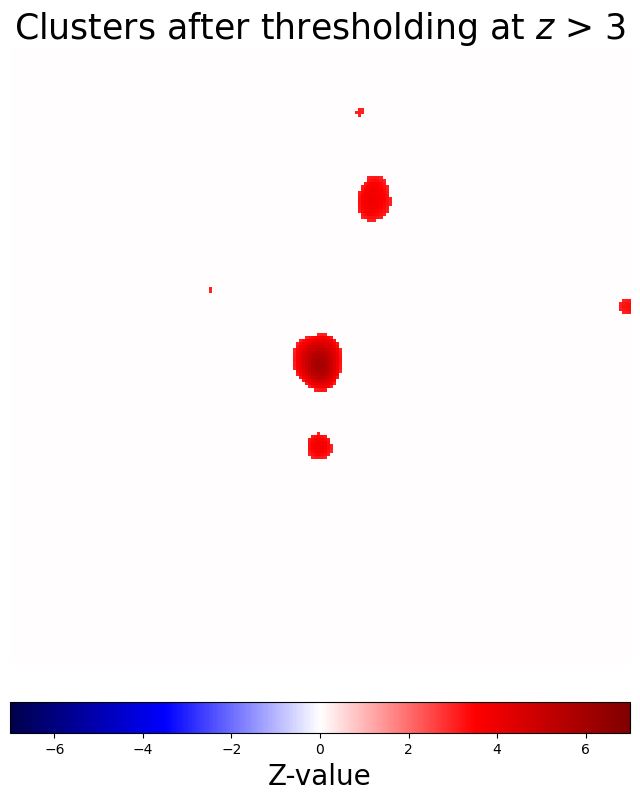

In [33]:
min_z = 3
thresh_data = (data > min_z)

plot_sim_brain(data, mask=thresh_data, title=r"Clusters after thresholding at $z$ > 3")

Now, we can use cluster-based RFT to calculate the $p$-value for each cluster in the above thresholded data plot. This $p$-value reflects the probably of this cluster-size (or larger) under the null-hypothesis. We can then threshold this map with clusters, using a 'cluster-wise' $p$-value cutoff of 0.01 for example, and plot it again to see how this method affects type 1 and type 2 errors. The function below (`threshold_RFT_cluster`) takes three arguments: the statistics-map (our `data` variable), a minimum $z$-value, and a $p$-value cutoff which is used to threshold the clusters.

Below, we do this for a $z$-threshold of 3.1 (corresponding to a $p$-value of approx. 0.001) and a cluster $p$-value threshold of 0.05.

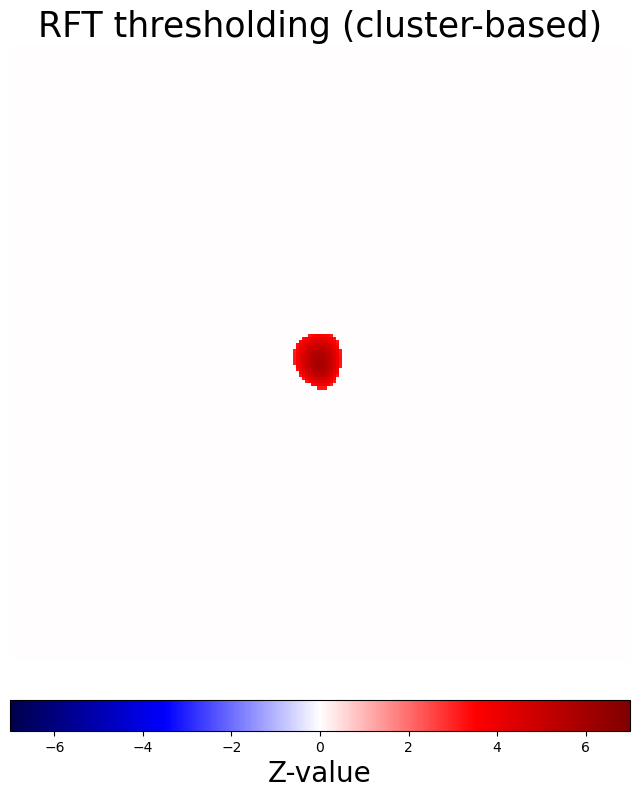

In [36]:
from niedu.utils.nii import rft_cluster_threshold

rft_cl_mask = rft_cluster_threshold(data, z_thresh=3.1, p_clust=0.01)
plot_sim_brain(data, mask=rft_cl_mask, title='RFT thresholding (cluster-based)')

From the above plots, you should see that cluster-thresholding can be a very sensitive way to threshold your data if you expect your effects to occur in relatively large clusters (and given that you're able to estimate the smoothness of the data appropriately, something that is a topic of debate). As such, it is by far the most used MCC method in univariate fMRI research today (but this does not necessarily mean it's the *best* way).

## Non-parametric MCC
In addition to the previously discussed MCC approaches (which are common in parametric group-level models), non-parametric analyses offer another approach. In this approach, the algorithm keeps track of the *maximum* statistic across permutations. This statistic can refer to the highest voxel-wise amplitude (for voxel-based), largest cluster size (for cluster-based, given some initial $z$-value cutoff), or even highest TFCE-transformed amplitude, across permutations.

If we, for example, want to perform a cluster-based non-parametric analyses, we can save the largest cluster size (given some initial $z$-value threshold) for each iteration. Then, across our (let's say) 5000 permutations, we have acquired a *distribution* of maximum cluster sizes under the null hypothesis of no effect. 

We actually did this for our simulated data: we kept track of the maximum cluster size across 1000 permutations given some initial $z$-value cutoff. We'll plot such a non-parametric distribution below (for an arbitrary $z$-value cutoff of 3):

In [ ]:
np_dist = np.load('clust_size_dist_data.npz')
zx, clust_sizes = np_dist['zx'], np_dist['dist']
z_cutoff = 3
z_idx = np.abs(zx - z_cutoff).argmin()
clust_size_dist = clust_sizes[:, z_idx]

plt.figure(figsize=(15, 5))
plt.title("Max. cluster size across 1000 permutations", fontsize=25)
plt.hist(clust_size_dist, bins=50)
plt.xlabel("Max. cluster size", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.grid()
plt.show()

With that information, we can calculate the non-parametric $p$-value of each of our *observed* clusters using the same type of formula as we used earlier:

\begin{align}
p_{\mathrm{cluster}} = \frac{\sum_{i=1}^{P}\mathbf{I}(\mathbf{\mathrm{max.\ cluster\ size}}^{\mathrm{perm}}_{i} \geq \mathrm{cluster\ size}^{\mathrm{obs}}) + 1}{P + 1}
\end{align}

The same logic holds for voxel-based (TFCE-transformed) amplitude, where you wouldn't keep track of the maximum cluster size, but the maximum amplitude across permutations.

<div class='alert alert-warning'>
    <b>ToDo</b> (ungraded/optional): Suppose I have found an effect within our simulated data with a cluster size of 231 "voxels" (using an initial $z$-value threshold of 3). Using the distribution of maximum cluster sizes above (i.e., the variable <tt>clust_size_dist</tt>), can you compute the associated cluster $p$-value? Store it in a variable named <tt>pval_clust_size</tt>.
</div> 

In [ ]:
""" Implement the (optional) ToDo here. """
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
''' Tests the above (optional) ToDo. '''
np.testing.assert_almost_equal(pval_clust_size, 0.001998)
print("Well done!")

In our experience, non-parametric analyses (e.g., `randomise` in FSL) in combination with TFCE (also supported in FSL) is a very sensitive approach, allowing for voxel-wise inference while taking into account the "blobbiness" of effects!

## Exercise on new data
Suppose we repeat the cat-picture experiment which we described earlier. Based on the literature, we expect to find strong activation in a small group of voxels &mdash; known as the *nucleus felix* &mdash; which is about 29 "voxels" in volume, located in the middle of the brain (here: our 2D brain). Like our other example, we've measured a group-level (2D) statistics ($z$-values) map which represents the cat-against-baseline contrast.

We'll load in and plot the new data below:

In [ ]:
data2 = np.load('data_assignment.npy')
plot_sim_brain(data2, title='Simulated data assignment', vmin=-10, vmax=10)

<div class='alert alert-warning'>
<b>ToDo/ToThink</b> (1 point): Given that cluster-based RFT correction worked really well in our last example, should we use this technique again on this dataset, given our expectations of the true effect?  Why (not)? Hint: actually apply the cluster-based RFT correction to the new data (you may assume that the new data has the same smoothness as the previous data).
</div>

In [ ]:
# Apply cluster-based RFT


YOUR ANSWER HERE

## Effect of different MCC strategies on real data
We actually ran group-level analyses (using FLAME1-type mixed-effects) with different MCC methods on our run-level $4\cdot \beta_{face} - \beta_{place} - \beta_{body} - \beta_{character} - \beta_{object}$ contrast from 12 subjects, which we download below:

In [ ]:
import os
data_dir = os.path.join(os.path.expanduser("~"), 'NI-edu-data')

print("Downloading group-level FSL FEAT results (+- 133MB) ...")
!aws s3 sync --no-sign-request s3://openneuro.org/ds003965 {data_dir} --exclude "*" --include "derivatives/fsl/grouplevel_task-flocBLOCKED/contrast-faceGTother_method-FLAME1*/*"
print("\nDone!")

In [ ]:
from glob import glob
fsl_deriv_dir = os.path.join(data_dir, 'derivatives', 'fsl')
gl_paths = sorted(glob(os.path.join(fsl_deriv_dir, 'grouplevel_task-flocBLOCKED', '*')))
print('\n'.join(gl_paths))

As you can see, there are results for three different MCC strategies:
* uncorrected (with $p < 0.05$);
* cluster-based (with $z > 3.1$ and $p_{\mathrm{cluster}} < 0.05$);
* voxel-based RFT (with $p_{\mathrm{voxel}} > 0.05$);
* non-parametric ("randomise" with TFCE, non-parametric $p < 0.05$)

Let's take a look at the thresholded $z$-statistic maps for each of those analyses.

<div class='alert alert-warning'>
    <b>ToDo</b> (ungraded): If not yet opened, open FSLeyes. Add the standard MNI brain as a background image (<tt>File</tt> &rarr; <tt>Add standard</tt> &rarr; select <tt>MNI152_T1_2mm_brain.nii.gz</tt>). Then, add the <tt>thresh_zstat1.nii.gz</tt> image from the <tt>contrast-faceGTother_method-FLAME1_thresh-uncorr05.gfeat/cope1.feat</tt> directory (<tt>File</tt> &rarr; <tt>Add from file</tt>). Change the colormap to "Red-Yellow".
</div>

You have seen this brain map before, and you should know by now that this brain map likely contains many false positives as it's not corrected for multiple comparisons. 

<div class='alert alert-warning'>
    <b>ToDo</b> (ungraded): Add the <tt>thresh_zstat1.nii.gz</tt> file from the <tt>contrast-faceGTother_method-FLAME1_thresh-cluster.gfeat/cope1.feat</tt> directory (<tt>File</tt> &rarr; <tt>Add from file</tt>). Change to colormap to "Blue-Light blue". 
</div>

Here, you see a much more modest effect, where only a couple of clusters (in the superior temporal gyrus and posterior cingulate cortex) survived.

<div class='alert alert-warning'>
    <b>ToDo</b> (ungraded): Add the <tt>thresh_zstat1.nii.gz</tt> file from the <tt>contrast-faceGTother_method-FLAME1_thresh-voxel.gfeat/cope1.feat</tt> directory, and change the colormap to "Green".
</div>

If you don't see any green voxels, that's right! No voxel "survived" the relatively conservative voxel-based RFT tresholding!

<div class='alert alert-warning'>
    <b>ToDo</b> (ungraded): Lastly, add the <tt>thresh_zstat1.nii.gz</tt> file from the <tt>contrast-faceGTother_method-randmoise_thresh-TFCE05.gfeat/cope1.feat</tt> directory, and change the colormap to "Blue".
</div>

This looks quite alright (in the sense that at least some voxels survive the MCC procedure)! Does this mean that we should always use cluster-based or non-parametric (TFCE-boosted) MCC? Not necessarily. Like always, this depends on your data, the effect you expect, and the conclusions that you want to draw from your results.

<div class='alert alert-success'>
    <b>Tip!</b>
    Before handing in your notebooks, we recommend restarting your kernel (<em>Kernel</em> &rarr; <em>Restart & Clear Ouput</em>) and running all your cells again (manually, or by <em>Cell</em> &rarr; <em>Run all</em>). By running all your cells one by one (from "top" to "bottom" of the notebook), you may spot potential errors that are caused by accidentally overwriting your variables or running your cells out of order (e.g., defining the variable 'x' in cell 28 which you then use in cell 15).
</div>